### Aluno : Samuel Rodrigues dos Santos  

# 1. Classes e Metodos 

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from d2l import tensorflow as d2l
import random

class LinearRegression(d2l.Module): #@save
    '''The linear regression model implemented with high-level APIs.'''
    '''Do d2l'''
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)

class LinearRegressionData(d2l.DataModule): #@save
    """Data for linear regression."""
    def __init__(self, nInputs,data,num_train=5197, num_val=1300,
         batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.X=data[:,0:nInputs]
        self.y=data[:,nInputs]


@d2l.add_to_class(d2l.DataModule) #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
        buffer_size=shuffle_buffer).batch(self.batch_size)

@d2l.add_to_class(LinearRegressionData) #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

2023-10-29 15:09:42.060686: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 15:09:44.310196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 15:09:44.320026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 15:09:51.991348: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. Leitura e Pré-processamento

In [2]:
data = pd.read_csv('winequalityN.csv')

#Retirando a coluna de string, substituindo a coluna type por duas colunas booleanas 'white','red'

data.insert(0,'red',data['type'] == 'red')     #Criando a coluna 'red' booleana na segunda posição 
data.insert(0,'white',data['type'] == 'white') #Criando a coluna 'white' booleana na primeira posição
data = data.drop('type',axis=1)                #Apagando o coluna 'type', que não possui mais funcao

#Substituindo dados Faltantes pela media de sua coluna 
data = data.fillna(data.mean())

#Separando 20% da validação
train_data, val_data = train_test_split(data, test_size=0.2) 

#Passando para Matrix 
train_data_matrix = tf.constant(train_data.to_numpy(dtype='float64')) 
val_data_matrix = tf.constant(val_data.to_numpy(dtype='float64')) 
#Concatenando primeiro dados de Treinamento depois de validação
dataMatrix = tf.concat([train_data_matrix, val_data_matrix], 0)

print(dataMatrix)

tf.Tensor(
[[ 0.    1.    9.3  ...  0.75 10.2   6.  ]
 [ 1.    0.    5.8  ...  0.36 10.9   7.  ]
 [ 1.    0.    5.9  ...  0.5  12.7   6.  ]
 ...
 [ 0.    1.    6.6  ...  0.89 12.3   7.  ]
 [ 1.    0.    7.1  ...  0.52 11.9   7.  ]
 [ 1.    0.    7.   ...  0.54  9.4   6.  ]], shape=(6497, 14), dtype=float64)


# 3 Treinamento

## 3.1 Métodos para treinamento

In [3]:
@d2l.add_to_class(LinearRegression) #@save
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression) #@save
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

@d2l.add_to_class(LinearRegression) #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

## 3.2 Treinamento conforme exemplo dado (aula5)

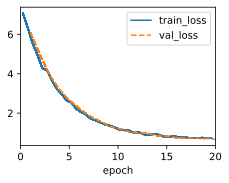

In [4]:
model = LinearRegression(lr=1e-5)                               #inicializando a classe para definir o modelo e definindo a taxa de aprendizado (lr)
data = LinearRegressionData(nInputs = 13, data = dataMatrix)    #passando os dado para um formato adequado para o treinamento , 13 entradas 
trainer = d2l.Trainer(max_epochs=20)                            #inicializando a classe trainer e definado a quantidade de epocas que usarei 
trainer.fit(model, data)                                        #usando o metodo fit para relalizar o treinamento da regressão 

# 4. Avaliações e análises

In [5]:
# Checando os valores que o modelo preve para as entradas presentes nos dados de validação 
prediction = model.call(val_data_matrix[:,:-1])                          #passando as 13 primeiras colunas de entrada, excluindo a ultima. Previsão dos valores de y
y_validacao = tf.constant(val_data_matrix[:,-1])                         #passando a ultima linha com as saidas corretas 
y_validacao = tf.reshape(y_validacao, (-1, 1))                           #colocando nas mesmas dimensões da predição 
prediction = tf.cast(prediction,tf.float64)                              #Colocando no mesmo formato que as saidas dos dados de validação (float64)

## 4.1 Erro absoluto médio e Preditor Trivial

Erro Médio Absoluto (MAE) = $\frac{1}{n} \ \sum\limits_{i=1}^{n} |y_i - \hat{y_i}|$

In [6]:
MAE_m = tf.reduce_mean(tf.abs(y_validacao - prediction))                 #Em relação ao modelo        
print(f'Erro absoluto medio do modelo = {MAE_m}')                        #Imprimindo o erro do modelo 

#Para o presitor trivial, usando a media das saidas do tensor de treinamento e comparando com a saida do tensor de validação 
y_train_media = tf.reduce_mean(train_data_matrix[:,-1])                        #Media das saidas do treinamento
prev_triv = tf.fill(y_validacao.shape, y_train_media)                    #Tensor com a mesma dimesões que a saidas da validação, sendo a previsão trivial
MAE_t = tf.reduce_mean(tf.abs(y_validacao - prev_triv))                  #Em relação ao preditor trivial 
print(f'Erro absoluto medio do Predito trivial = {MAE_t}')               #Imprimindo o erro trivial

Erro absoluto medio do modelo = 0.6466669948284443
Erro absoluto medio do Predito trivial = 0.6796523142049409


Como esperado a predição realizada por nossa Regreção linear possui valor de MAE menor que 1 o que confirma que erramos menos de uma categoria intera, como dito nas instruções. Gerando uma previsão melhor do que uma simples média feita pelo preditor trivial, porém com erro apenas 0.03 melhor.

## 4.2 Classificação por arredondamento

In [7]:
#Separando em 7 clases

limites = [1, 2, 3, 4, 5, 6, 7]                                            #Definindo os limites das classes (de 1 a 7)

def separa_classes(tensor_class):                                          #Função para separar classes
    # Criando máscaras para cada intervalo
    mascaras = [tf.logical_and(tensor_class >= limites[i-1], tensor_class < limites[i]) for i in range(1, len(limites))]
    classes = [i + 1 for i, mascara in enumerate(mascaras)]                # Atribuindo uma classe para cada intervalo (de 1 a 7)
    classe_tensor = tf.where(mascaras[0], classes[0], 0)                   # Caso não cumpra nenhuma das condição deve ser um valor muito incorreto, atribuo 0  
    for i in range(1, len(classes)):
        classe_tensor = tf.where(mascaras[i], classes[i], classe_tensor)   # Usando tf.where para criar um tensor com as classes correspondentes
    return classe_tensor

def calc_acuracia(tensor_comp):                                            # Calcula a acuracia comparando com a saida da validação 
    #Comparando os valores obtidos com os corretos da validação , para obter o numero de acertos
    certos = tf.equal(tensor_comp, classe_val) 
    return tf.reduce_mean(tf.cast(certos, dtype=tf.float64))               # obtendo a taxa de acertos usando a media dos acertos

#Saidas da validação 
classe_val = separa_classes(y_validacao)

#Saidas da predição  
classe_pred = separa_classes(prediction)

#Acuracia da regreção
acuracia_regre = calc_acuracia(classe_pred)
print(f'Acuracia de {np.around(acuracia_regre*100,5)}%')                       

#Preditor aleatório, criando tensor aleatorio de distruição uniforme e classificar 
tensor_aleatorio = tf.random.uniform(shape=y_validacao.shape, minval=1, maxval=7, dtype=tf.float64)
preditor_aleatorio = separa_classes(tensor_aleatorio)
acuracia_aleat = calc_acuracia(preditor_aleatorio)
print(f'Acuracia do preditor aleatório de {np.around(acuracia_aleat*100,5)}%')  

Acuracia de 39.15385%
Acuracia do preditor aleatório de 13.76923%


Como as intruções afirma o preditor aleatorio realmente te uma taxa de acerto de aproximadamente 14%, e a taxa do preditor de regressão linear que usmos tem aproximadamente 38% que embora seja superior ao aleatorio ainda não tem uma boa acuracio , oque como e enfatizado os dados não estão bem tratatos e possuem grande variabilidade, bem como estamos usando um modelo linear para um problema obviamente não linear .

## 5.3. Correlação

In [8]:
import tensorflow_probability as tfp 

corre_pred = tfp.stats.correlation(prediction,y_validacao)              #função para o calculo da correlação entre a predição da regressão e os dados de validação 
corre_ale = tfp.stats.correlation(tensor_aleatorio,y_validacao)         #função para o calculo da correlação entre um tensor aletorio(criado na celula anterior) e os dados de validação 

print(f'Correlação entre nosso sistema e os dados de validação = {corre_pred}')
print(f'Correlação entre um tensor aleatorio e os dados de validação = {corre_ale}')

Correlação entre nosso sistema e os dados de validação = [[0.36469711]]
Correlação entre um tensor aleatorio e os dados de validação = [[0.04497489]]


A correlação é aproximadamente 0,3250. O valor positivo indica que a saída dos dados de teste e a saída do nosso modelo de regressão possuem uma alta relação entre si, o que era esperado, já que desejamos que a relação entre nossa previsão e validação seja a máxima possível, uma vez que estamos buscando prever esses dados. Isso fica evidente ao observar a correlação obtida ao compará-la com um vetor aleatório de valor -0,02091, que é negativo, indicando a ausência de relação. Vale a pena ressaltar que, devido às razões já especificadas, esse valor não está tão próximo de 1 como seria o ideal.

## 5.5 . Provocação

Acredito que a nossa rede é capaz de resolver um problema de otimização estatística. Portanto, sistemas mais complexos não aprendem a classificar vinhos, mas sim a encontrar padrões para resolver eficientemente problemas numéricos. A aplicação desta otimização é escolhida por nós, e atribuímos significado a ela. Embora a própria capacidade de um especialista em vinhos provavelmente tenha sido obtida com muito treinamento, visando a máxima eficiência em reconhecer esses padrões, o mesmo ocorre com uma IA que executa tarefas com objetivos específicos. Ambos exigem um alto volume de informações sobre vinhos e compartilham a característica de autonomia no aprendizado, pois mesmo que recebam ajuda externa, o aprendizado ocorre individualmente. Portanto, em minha concepção, ela não aprendeu a classificar vinhos, mas sim a reconhecer padrões. No entanto, caso fosse restrita e especificada a tarefa de classificação, há uma alta chance de afirmar que ela foi capaz de aprender.